In diesem Jupyternotebook wird es um einen Vergleich zwischen der Arealstatistik und dem WorldCover 2020 Datensatz gehen.

In [43]:
# Change to your environment variables for PROJ and GDAL to ensure proper functioning of geospatial libraries.
import os
os.environ["PROJ_LIB"] = r"C:\Users\alexa\anaconda3\envs\WC\Library\share\proj"
os.environ["GDAL_DATA"] = r"C:\Users\alexa\anaconda3\envs\WC\Library\share\gdal"

# installieren von openpyxl, matplotlib, seaborn, scikit-learn falls noch nicht vorhanden
# pip install openpyxl
# pip install matplotlib
# pip install seaborn
# pip install scikit-learn

# define data paths for data files
DATA_PATH = "../../../../data"
ANALYSES_PATH = DATA_PATH + "/analysis/worldcover/centerpoint"
PREPROCESSING_PATH = DATA_PATH + "/preprocessing/worldcover/2020"


Raster auf die gleiche Auflösung bringen (erstmals nur für Zug)

In [44]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask

# Paths
raster_path = PREPROCESSING_PATH +"/worldcover_2020_clipped.tif"
mask_path =  DATA_PATH +"/analysis/arealstatistik/arealstatistik_grid_zug_100m.gpkg"

# Read buffered border
mask_gdf = gpd.read_file(mask_path)
print(mask_gdf.crs)

EPSG:2056


In [45]:
mask_geom = [mask_gdf.union_all()]  # Combine if multiple polygons

In [46]:
with rasterio.open(raster_path) as src:
    clipped_array, clipped_transform = mask(
        dataset=src,
        shapes=mask_geom,
        crop=True,
        nodata=0
    )
    clipped_meta = src.meta.copy()

clipped_meta.update({
    "driver": "GTiff",
    "height": clipped_array.shape[1],
    "width": clipped_array.shape[2],
    "transform": clipped_transform,
})

Raster speichern

In [47]:
out_path =  ANALYSES_PATH+"/worldcover_2020_clipped_zug.tif"
with rasterio.open(out_path, "w", **clipped_meta) as dest:
    dest.write(clipped_array)

Raster werte den Polygonen zuordnen (häufigste Klasse pro Polygon)

In [48]:
import geopandas as gpd
from rasterstats import point_query
import pandas as pd

# Punktlayer laden
punkte_gdf = gpd.read_file(DATA_PATH+"/analysis/arealstatistik/ag-b-00.03-37-area-all-gpkg_zug.gpkg")

# Pfad zum Raster
worldcover_raster = ANALYSES_PATH+"/worldcover_2020_clipped_zug.tif"

# Rasterwert an jedem Punkt abfragen
values = point_query(punkte_gdf, worldcover_raster, interpolate='nearest', nodata=0)

# Werte als neue Spalte speichern
punkte_gdf["WorldCover_2020_class"] = values

# Ergebnis speichern
punkte_gdf.to_file(ANALYSES_PATH+"/arealstatistik_zug_with_wc.gpkg", driver="GPKG")


Arealstatistik Klassen den WorldCover Klassen zuordnen

In [49]:
import geopandas as gpd
import pandas as pd

# Arealstatistik-Daten laden
polygons = gpd.read_file(ANALYSES_PATH+"/arealstatistik_zug_with_wc.gpkg", driver="GPKG")

# Excel-Mappingtabelle laden
mapping_df = pd.read_excel(DATA_PATH+"/analysis/worldcover/Mapping_AS_WC.xlsx")

# Angenommen, die Excel-Datei hat zwei Spalten: "AS18_72" und "WorldCover_class"
# Erstelle ein Mapping-Dictionary
mapping_dict = dict(zip(mapping_df["AS18_72"], mapping_df["WorldCover_class"]))

# Neue Spalte mit WorldCover Klassen erstellen basierend auf der Zuordnung
polygons["AS_auf_WorldCover"] = polygons["AS18_72"].map(mapping_dict)

# Fehlende Werte mit -1 ersetzen, ohne inplace=True
polygons["AS_auf_WorldCover"] = polygons["AS_auf_WorldCover"].fillna(-1)


# Ergebnis speichern
polygons.to_file(ANALYSES_PATH+"/arealstatistik_zug_mapped.gpkg", driver="GPKG")


c:\Users\jonas\anaconda3\envs\worldcover\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver GPKG does not support open option DRIVER
  return ogr_read(


Confusion Matrix erstellen und auswerten

c:\Users\jonas\anaconda3\envs\worldcover\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver GPKG does not support open option DRIVER
  return ogr_read(


<Figure size 800x600 with 0 Axes>

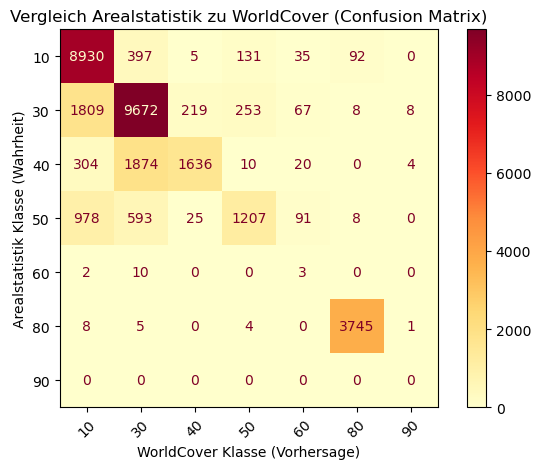

In [50]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# GeoDataFrame laden
df = gpd.read_file(ANALYSES_PATH+"/arealstatistik_zug_mapped.gpkg", driver="GPKG")

# Klassen vergleichen
y_true = df["AS_auf_WorldCover"]
y_pred = df["WorldCover_2020_class"]

# Alle Klassen bestimmen
labels = sorted(set(y_true).union(set(y_pred)))

# Confusion Matrix erstellen
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Deutsche Achsen und Matrix anzeigen
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="YlOrRd", xticks_rotation=45)
plt.title("Vergleich Arealstatistik zu WorldCover (Confusion Matrix)")
plt.xlabel("WorldCover Klasse (Vorhersage)")
plt.ylabel("Arealstatistik Klasse (Wahrheit)")
plt.tight_layout()
plt.show()


Confusion Matrix erstellen zum verifizieren der Klassenzuordnung

In [51]:
import geopandas as gpd
import pandas as pd

# GeoDataFrame laden
df = gpd.read_file(ANALYSES_PATH+"/arealstatistik_zug_mapped.gpkg", driver="GPKG")

# Kreuztabelle erstellen:
crosstab = pd.crosstab(
    df["AS18_72"],                      # Zeilen: originale AS Klassen
    df["WorldCover_2020_class"],      # Spalten: WorldCover Klassen
    rownames=["AS18_72"],               # Deutsche Achsen-Beschriftungen
    colnames=["WorldCover_2020_class"]
)

# Tabelle zeigen/prüfen
print(crosstab)

# Optional: Als Excel oder CSV abspeichern
crosstab.to_csv(ANALYSES_PATH+"/AS_WC_kreuztabelle_zug.csv")
crosstab.to_excel(ANALYSES_PATH+"/AS_WC_kreuztabelle_zug.xlsx")


c:\Users\jonas\anaconda3\envs\worldcover\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: driver GPKG does not support open option DRIVER
  return ogr_read(


WorldCover_2020_class   10   30  40   50  60  80  90
AS18_72                                             
1                        6    2   0  139   2   0   0
2                       24    6   2  171  12   1   0
3                       83   20   0   38   1   1   0
4                      281  100   2   88   3   1   0
5                       18    3   0   19   0   0   0
...                    ...  ...  ..  ...  ..  ..  ..
67                     154  612   1    0   0   7   8
68                       1    0   0    0   0   0   0
69                       2    6   0    0   2   0   0
70                       0    4   0    0   1   0   0
71                       0    7   1    0   0   0   0

[67 rows x 7 columns]
